In [5]:
# Step 1️⃣: Import required libraries
import pandas as pd
# Step 2️⃣: Read dataset from Google Drive link
url = "https://drive.google.com/uc?id=1VUb9ucTsroGDBOPcwpOfXwzDi-rd4wqQ"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

# Confirm successful load
print("✅ Dataset successfully loaded!")
print("Shape of dataset:", df.shape)

# Display first 5 rows
df.head()

# Step 3️⃣: Basic Info
df.info()

# Step 4️⃣: Check for missing values
print("\n🔍 Missing Values per Column:\n", df.isna().sum())

# Step 5️⃣: Check for duplicates
print("\n🔁 Duplicate Rows:", df.duplicated().sum())

# Step 6️⃣: Display column names
print("\n📋 Column Names:\n", df.columns.tolist())

# Step 2️⃣: DATA UNDERSTANDING

# Check the shape of the dataset
print("Shape of dataset (rows, columns):", df.shape)

# Display column data types and non-null counts
print("\n📊 Dataset Info:")
df.info()
 # Check for missing values
print("\n🔍 Missing Values per Column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\n🔁 Number of duplicate rows:", df.duplicated().sum())
# Check how many unique values are in each column
print("\n🧩 Unique Values per Column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")





✅ Dataset successfully loaded!
Shape of dataset: (212345, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212345 entries, 0 to 212344
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               212345 non-null  int64  
 1   tpep_pickup_datetime   212345 non-null  object 
 2   tpep_dropoff_datetime  212345 non-null  object 
 3   passenger_count        212345 non-null  int64  
 4   pickup_longitude       212345 non-null  float64
 5   pickup_latitude        212345 non-null  float64
 6   RatecodeID             212345 non-null  int64  
 7   store_and_fwd_flag     212345 non-null  object 
 8   dropoff_longitude      212345 non-null  float64
 9   dropoff_latitude       212345 non-null  float64
 10  payment_type           212345 non-null  int64  
 11  fare_amount            212345 non-null  float64
 12  extra                  212345 non-null  float64
 13  mta_tax                2123

In [7]:

# feature engineering
import numpy as np
from math import radians, sin, cos, asin, sqrt
import pandas as pd
# Define Haversine function to calculate trip distance
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r  # Distance in kilometers

# Apply function to create new 'trip_distance' column
df['trip_distance'] = df.apply(lambda row: haversine_distance(
    row['pickup_latitude'], row['pickup_longitude'],
    row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

print("✅ Added column: trip_distance (in km)")
df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_distance']].head()
# Convert pickup datetime column to datetime if not already
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Convert UTC to EDT (Eastern Daylight Time)
df['pickup_datetime_edt'] = df['tpep_pickup_datetime'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

print("✅ Converted pickup_datetime from UTC to EDT")
df[['tpep_pickup_datetime', 'pickup_datetime_edt']].head()


# Extract useful time components
df['pickup_hour'] = df['pickup_datetime_edt'].dt.hour
df['pickup_day'] = df['pickup_datetime_edt'].dt.day_name()
df['pickup_month'] = df['pickup_datetime_edt'].dt.month
df['pickup_date'] = df['pickup_datetime_edt'].dt.date
df['pickup_weekday'] = df['pickup_datetime_edt'].dt.weekday  # Monday=0, Sunday=6


# Weekend indicator
df['is_weekend'] = df['pickup_weekday'].apply(lambda x: 1 if x >= 5 else 0)

# AM or PM
df['am_pm'] = df['pickup_hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

# Night-time flag (example: 10 PM - 5 AM)
df['is_night'] = df['pickup_hour'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)


df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

print("✅ Added feature: trip_duration_min (in minutes)")


# Display the newly created columns
new_cols = ['trip_distance', 'pickup_hour', 'pickup_day', 'pickup_month',
            'is_weekend', 'am_pm', 'is_night', 'trip_duration_min']
df[new_cols].head()


# Check for missing values or unrealistic distances
print("\n🔍 Missing Values in Engineered Features:\n", df[new_cols].isnull().sum())

# Example: Remove trips with zero or extremely large distances
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 100)]

print("\n✅ Feature engineering complete!")
print("Shape after cleaning:", df.shape)



✅ Added column: trip_distance (in km)
✅ Converted pickup_datetime from UTC to EDT
✅ Added feature: trip_duration_min (in minutes)

🔍 Missing Values in Engineered Features:
 trip_distance        0
pickup_hour          0
pickup_day           0
pickup_month         0
is_weekend           0
am_pm                0
is_night             0
trip_duration_min    0
dtype: int64

✅ Feature engineering complete!
Shape after cleaning: (208822, 29)


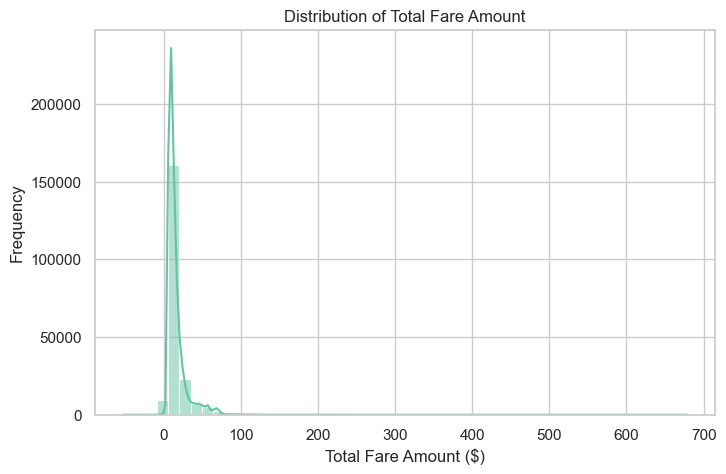

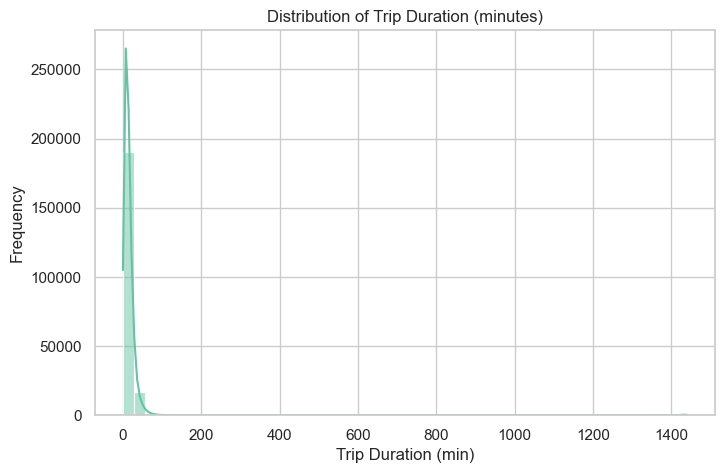

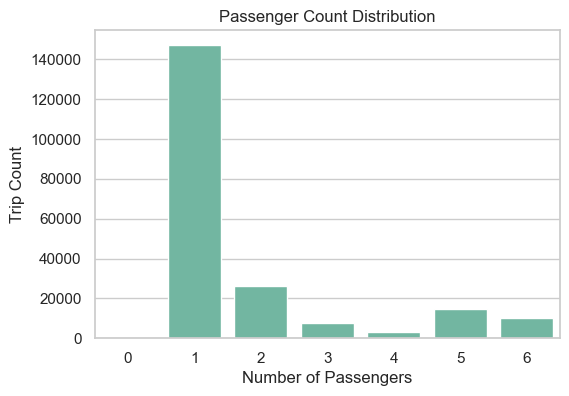

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles for better visuals
sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(8,5))
sns.histplot(df['total_amount'], bins=50, kde=True)
plt.title('Distribution of Total Fare Amount')
plt.xlabel('Total Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

#Trip Duration Distribution

plt.figure(figsize=(8,5))
sns.histplot(df['trip_duration_min'], bins=50, kde=True)
plt.title('Distribution of Trip Duration (minutes)')
plt.xlabel('Trip Duration (min)')
plt.ylabel('Frequency')
plt.show()

#Passenger Count Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='passenger_count', data=df)
plt.title('Passenger Count Distribution')
plt.xlabel('Number of Passengers')
plt.ylabel('Trip Count')
plt.show()



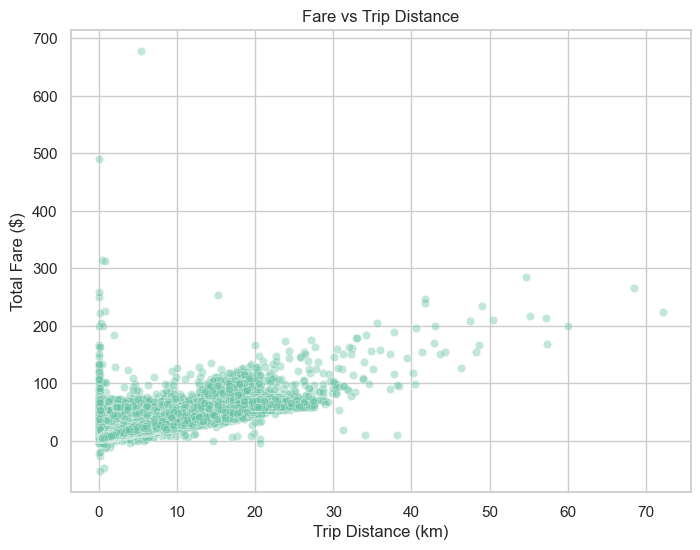

In [9]:
#BIVARIATE ANALYSIS              

#expect a positive correlation — longer trips generally have higher fares.

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x='trip_distance', y='total_amount', data=df, alpha=0.4)
plt.title('Fare vs Trip Distance')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Total Fare ($)')
plt.show()


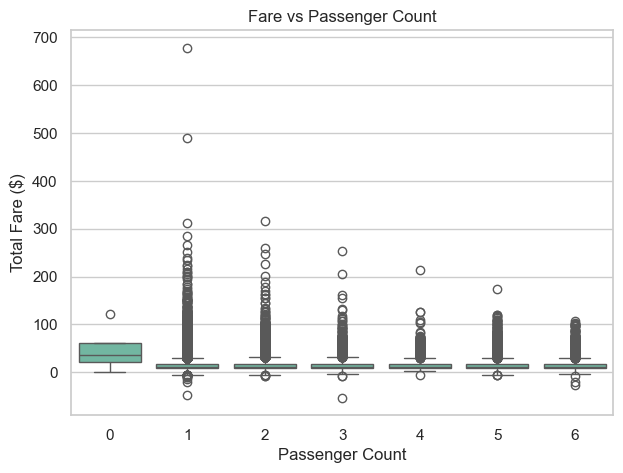

In [10]:
#Fare vs. Passenger Count                Most rides likely have 1–2 passengers.Fares usually don’t vary much by passenger count (flat-rate pricing).

plt.figure(figsize=(7,5))
sns.boxplot(x='passenger_count', y='total_amount', data=df)
plt.title('Fare vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Total Fare ($)')                         
plt.show()

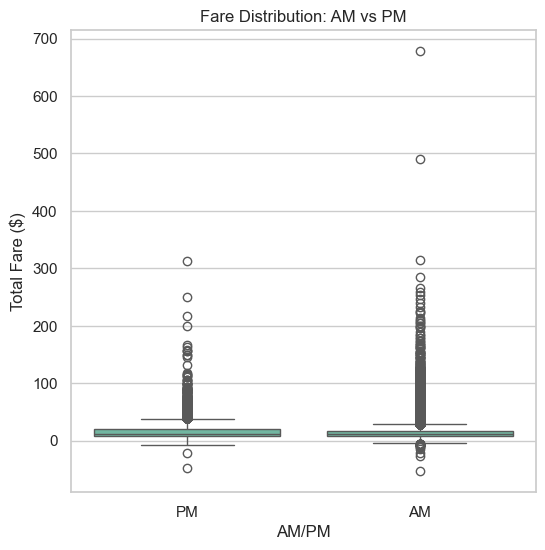

In [11]:
#Fare by Time of Day (AM/PM)       PM fares>Am

plt.figure(figsize=(6,6))
sns.boxplot(x='am_pm', y='total_amount', data=df)
plt.title('Fare Distribution: AM vs PM')
plt.xlabel('AM/PM')
plt.ylabel('Total Fare ($)')
plt.show()

In [12]:
df.groupby('am_pm')['total_amount'].mean()

am_pm
AM    15.477817
PM    17.154215
Name: total_amount, dtype: float64

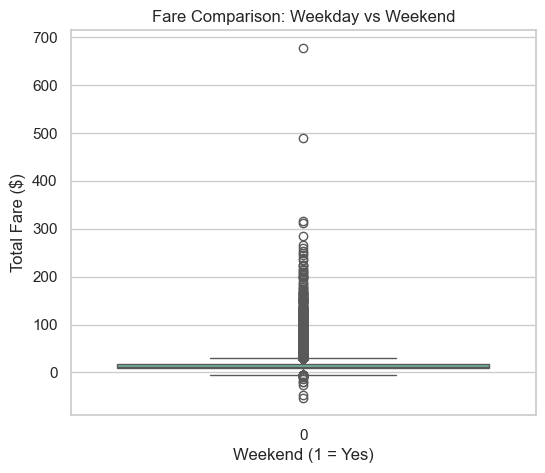

In [13]:
#Fare by Weekday vs Weekend

plt.figure(figsize=(6,5))
sns.boxplot(x='is_weekend', y='total_amount', data=df)
plt.title('Fare Comparison: Weekday vs Weekend')
plt.xlabel('Weekend (1 = Yes)')
plt.ylabel('Total Fare ($)')
plt.show()

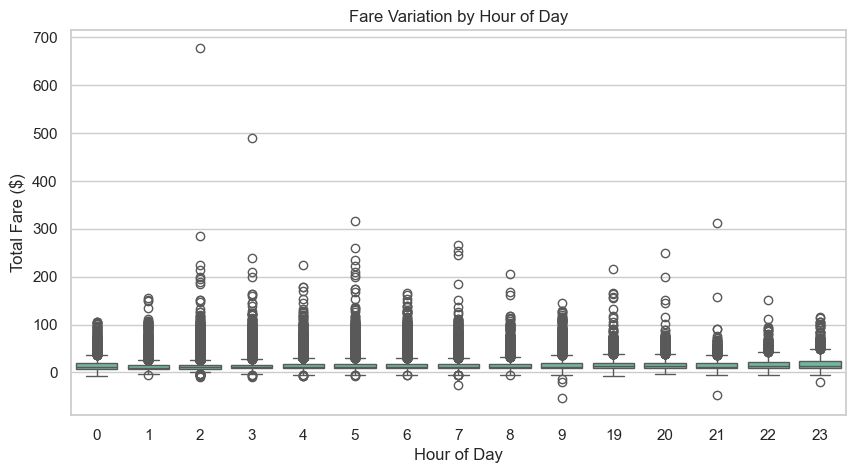

In [14]:
#Fare vs. Hour of Day
plt.figure(figsize=(10,5))
sns.boxplot(x='pickup_hour', y='total_amount', data=df)
plt.title('Fare Variation by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Fare ($)')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_18640\2675347112.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='pickup_day', y='total_amount', data=df, estimator='mean', ci=None)


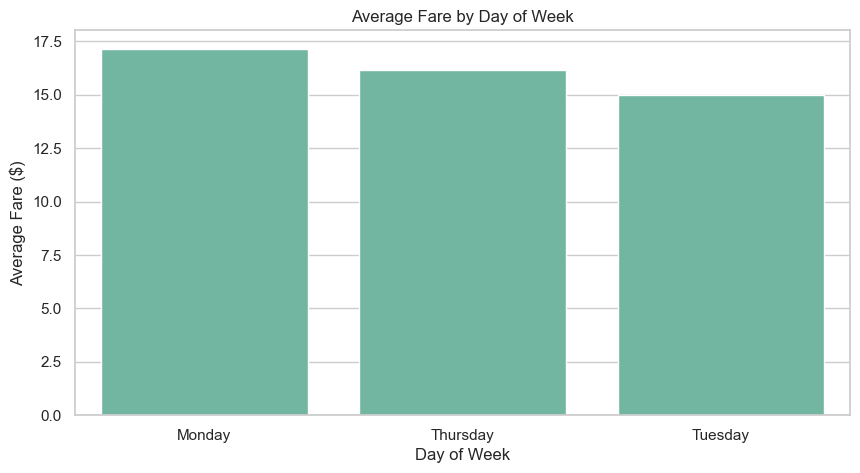

In [15]:
#Average Fare by Day of Week
plt.figure(figsize=(10,5))
sns.barplot(x='pickup_day', y='total_amount', data=df, estimator='mean', ci=None)
plt.title('Average Fare by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Fare ($)')
plt.show()

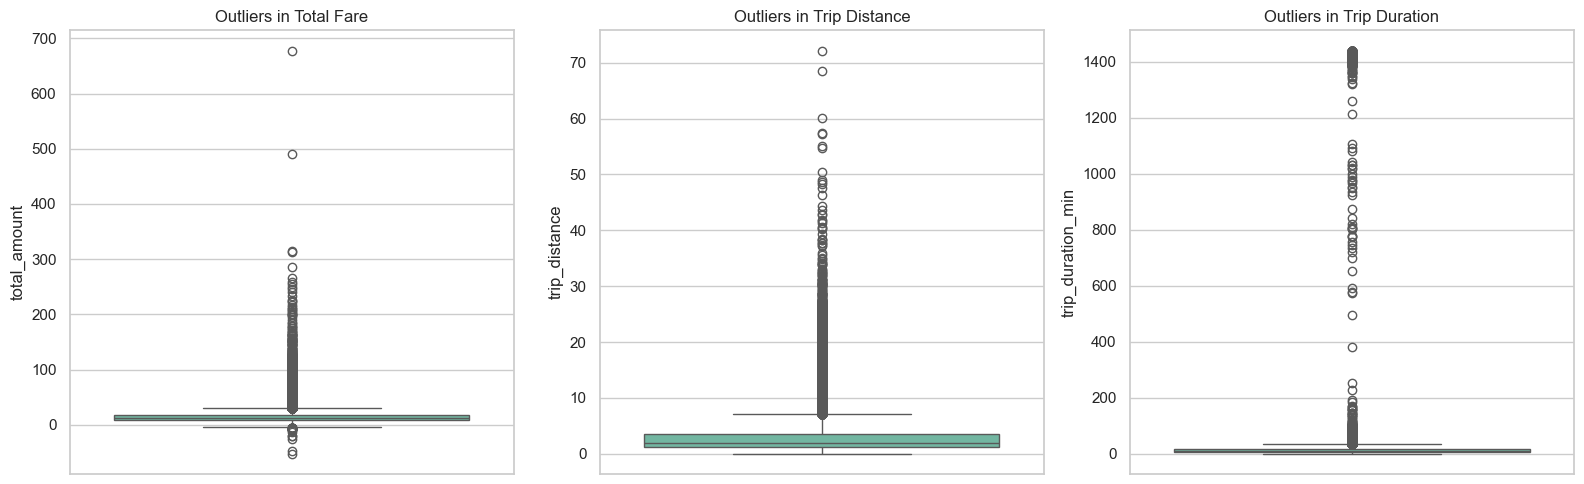

In [16]:
# OUTLIER DETECTION

#Boxplots for Key Variables

fig, ax = plt.subplots(1, 3, figsize=(16,5))

sns.boxplot(y=df['total_amount'], ax=ax[0])
ax[0].set_title('Outliers in Total Fare')

sns.boxplot(y=df['trip_distance'], ax=ax[1])
ax[1].set_title('Outliers in Trip Distance')

sns.boxplot(y=df['trip_duration_min'], ax=ax[2])
ax[2].set_title('Outliers in Trip Duration')

plt.tight_layout()
plt.show()



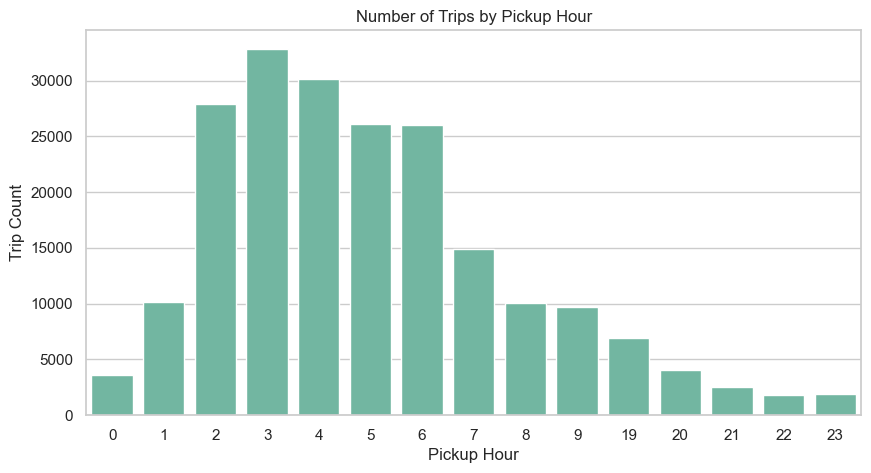

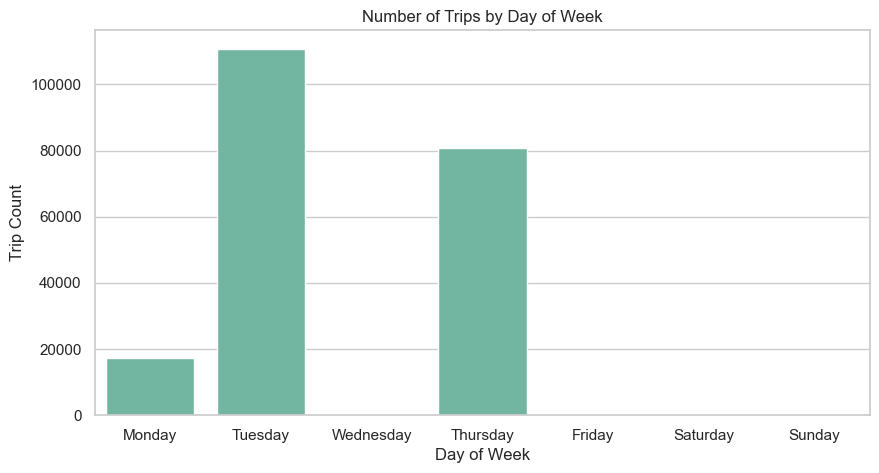

In [17]:
#PEAK DEMAND ANALYSIS

#Trip Counts by Hour

plt.figure(figsize=(10,5))
sns.countplot(x='pickup_hour', data=df)
plt.title('Number of Trips by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Count')
plt.show()


#Trip Counts by Day of Week

plt.figure(figsize=(10,5))
sns.countplot(x='pickup_day', data=df, order=[
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Number of Trips by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Trip Count')
plt.show()




In [15]:
df['pickup_day'].unique()


array(['Monday', 'Thursday', 'Tuesday'], dtype=object)

In [16]:
df['tpep_pickup_datetime'].min(), df['tpep_pickup_datetime'].max()


(Timestamp('2016-03-01 00:00:00'), Timestamp('2016-03-10 14:55:41'))

In [18]:
import numpy as np

# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

# Apply to key numeric columns
cols_to_check = ['total_amount', 'trip_distance', 'fare_amount', 'tip_amount', 'trip_duration_min']

for col in cols_to_check:
    before = df.shape[0]
    df = remove_outliers_iqr(df, col)
    after = df.shape[0]
    print(f"{col}: Removed {before - after} outliers")

df.shape


total_amount: Removed 18409 outliers
trip_distance: Removed 10858 outliers
fare_amount: Removed 4284 outliers
tip_amount: Removed 545 outliers
trip_duration_min: Removed 2450 outliers


(172276, 29)

In [18]:
df[cols_to_check].skew().sort_values(ascending=False)


trip_distance        1.016311
total_amount         0.675795
trip_duration_min    0.658981
fare_amount          0.637028
tip_amount           0.510149
dtype: float64

In [19]:
# Apply log1p (log(x+1)) to handle zeros safely
for col in cols_to_check:
    if df[col].skew() > 1:
        df[col] = np.log1p(df[col])
        print(f"Applied log1p to {col}")


Applied log1p to trip_distance


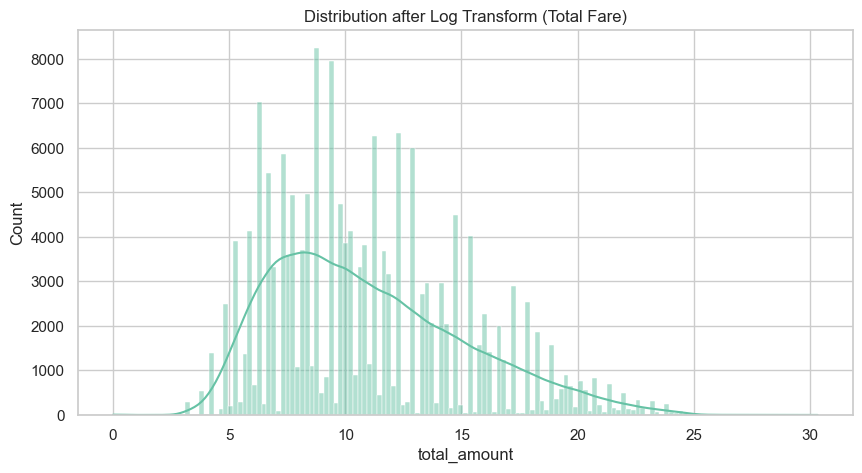

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df['total_amount'], kde=True)
plt.title('Distribution after Log Transform (Total Fare)')
plt.show()


In [21]:
!pip install scikit-learn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 
                    'payment_type', 'am_pm', 'is_night', 'is_weekend']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Optional: One-hot encoding for day of week
df = pd.get_dummies(df, columns=['pickup_day'], drop_first=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 172276 entries, 0 to 212343
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype                     
---  ------                 --------------   -----                     
 0   VendorID               172276 non-null  int64                     
 1   tpep_pickup_datetime   172276 non-null  datetime64[ns]            
 2   tpep_dropoff_datetime  172276 non-null  datetime64[ns]            
 3   passenger_count        172276 non-null  int64                     
 4   pickup_longitude       172276 non-null  float64                   
 5   pickup_latitude        172276 non-null  float64                   
 6   RatecodeID             172276 non-null  int64                     
 7   store_and_fwd_flag     172276 non-null  int64                     
 8   dropoff_longitude      172276 non-null  float64                   
 9   dropoff_latitude       172276 non-null  float64                   
 10  payment_type           17

In [23]:
df.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance', 'pickup_datetime_edt', 'pickup_hour', 'pickup_month',
       'pickup_date', 'pickup_weekday', 'is_weekend', 'am_pm', 'is_night',
       'trip_duration_min', 'pickup_day_Thursday', 'pickup_day_Tuesday'],
      dtype='object')

In [24]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()


In [25]:
df['pickup_day'].unique()


array(['Tuesday', 'Thursday'], dtype=object)

In [23]:
# 1. Show columns to ensure we have the datetime column
print("Columns:", df.columns.tolist())

# 2. Check the dtype and some sample values of the datetime column(s)
print("\nDatetime cols and dtypes:")
for c in ['tpep_pickup_datetime', 'pickup_datetime_edt']:
    if c in df.columns:
        print(c, "dtype:", df[c].dtype, "| sample:", df[c].dropna().head(3).tolist())
    else:
        print(c, "NOT IN DF")

# 3. Show unique pickup_day values and counts (if column exists)
if 'pickup_day' in df.columns:
    print("\nExisting pickup_day unique values and counts:")
    print(df['pickup_day'].value_counts(dropna=False))
else:
    print("\npickup_day NOT in dataframe")


Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'trip_distance', 'pickup_datetime_edt', 'pickup_hour', 'pickup_month', 'pickup_date', 'pickup_weekday', 'is_weekend', 'am_pm', 'is_night', 'trip_duration_min', 'pickup_day_Thursday', 'pickup_day_Tuesday']

Datetime cols and dtypes:
tpep_pickup_datetime dtype: datetime64[ns] | sample: [Timestamp('2016-03-01 00:00:00'), Timestamp('2016-03-01 00:00:00'), Timestamp('2016-03-01 00:00:01')]
pickup_datetime_edt dtype: datetime64[ns, US/Eastern] | sample: [Timestamp('2016-02-29 19:00:00-0500', tz='US/Eastern'), Timestamp('2016-02-29 19:00:00-0500', tz='US/Eastern'), Timestamp('2016-02-29 19:00:01-0500', tz='US/Eastern')]

pickup_day NOT in dataframe


In [24]:
# Ensure the datetime column is proper
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

# Create pickup_day from the datetime (use timezone-corrected column if you prefer)
# If you previously created pickup_datetime_edt (tz-aware), use that instead:
if 'pickup_datetime_edt' in df.columns:
    # If tz-aware dtype, convert to naive local time before extracting names
    try:
        df['pickup_day'] = df['pickup_datetime_edt'].dt.day_name()
    except Exception:
        # fallback to original UTC timestamp
        df['pickup_day'] = df['tpep_pickup_datetime'].dt.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('US/Eastern').dt.day_name()
else:
    df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()

print("Recreated pickup_day. Unique values:")
print(df['pickup_day'].unique())
print("\nCounts:")
print(df['pickup_day'].value_counts(dropna=False))


Recreated pickup_day. Unique values:
['Monday' 'Thursday' 'Tuesday']

Counts:
pickup_day
Tuesday     93760
Thursday    66220
Monday      12296
Name: count, dtype: int64


In [28]:
df['pickup_day'].value_counts(dropna=False)

pickup_day
Tuesday     93760
Thursday    66220
Monday      12296
Name: count, dtype: int64

In [25]:
# Normalize strings and strip whitespace
df['pickup_day'] = df['pickup_day'].astype(str).str.strip()  # converts NaN -> 'nan' if any; next step will handle that

# Show if there are lowercased or whitespace variants
print("Distinct lowercase variants:", df['pickup_day'].str.lower().unique())

# Convert proper NaN back (if any 'nan' strings appeared)
df.loc[df['pickup_day'].str.lower() == 'nan', 'pickup_day'] = pd.NA

print("\nAfter normalization, counts:")
print(df['pickup_day'].value_counts(dropna=False))


Distinct lowercase variants: ['monday' 'thursday' 'tuesday']

After normalization, counts:
pickup_day
Tuesday     93760
Thursday    66220
Monday      12296
Name: count, dtype: int64


In [26]:
# Create numeric weekday (Monday=0)
df['pickup_weekday_num'] = df['tpep_pickup_datetime'].dt.weekday

print("Unique weekday numbers present:", sorted(df['pickup_weekday_num'].dropna().unique()))

# Show a few rows where weekday == 0 (Monday) if any
monday_rows = df[df['pickup_weekday_num'] == 0]
print("Number of rows where weekday == 0 (Monday):", len(monday_rows))
if len(monday_rows) > 0:
    display(monday_rows[['tpep_pickup_datetime','pickup_weekday_num']].head())
else:
    print("No rows with weekday == 0 were found.")


Unique weekday numbers present: [np.int32(1), np.int32(3)]
Number of rows where weekday == 0 (Monday): 0
No rows with weekday == 0 were found.


In [31]:
df['pickup_weekday_num'].unique()

array([1, 3], dtype=int32)

In [32]:
# Check dataset date-range and sample of dates
print("Min/Max pickup datetimes:", df['tpep_pickup_datetime'].min(), df['tpep_pickup_datetime'].max())
print("\nSample of dates and weekday names:")
display(df[['tpep_pickup_datetime','pickup_day']].dropna().head(20))


Min/Max pickup datetimes: 2016-03-01 00:00:00 2016-03-10 14:55:41

Sample of dates and weekday names:


,tpep_pickup_datetime,pickup_day
0,2016-03-01 00:00:00,Monday
1,2016-03-01 00:00:00,Monday
8,2016-03-01 00:00:01,Monday
10,2016-03-01 00:00:01,Monday
11,2016-03-01 00:00:02,Monday
12,2016-03-01 00:00:02,Monday
13,2016-03-01 00:00:02,Monday
15,2016-03-01 00:00:02,Monday
16,2016-03-01 00:00:03,Monday
17,2016-03-01 00:00:03,Monday


In [27]:
mask = df['pickup_weekday_num'] == 0
df.loc[mask, 'pickup_day'] = 'Monday'
print("Fixed labels for Monday. Counts now:")
print(df['pickup_day'].value_counts(dropna=False))


Fixed labels for Monday. Counts now:
pickup_day
Tuesday     93760
Thursday    66220
Monday      12296
Name: count, dtype: int64


In [34]:
# Recreate pickup_day and weekday number from EDT (US Eastern Time)
df['pickup_datetime_edt'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce') \
                                .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

df['pickup_day'] = df['pickup_datetime_edt'].dt.day_name()
df['pickup_weekday_num'] = df['pickup_datetime_edt'].dt.weekday

print(df[['pickup_day', 'pickup_weekday_num']].value_counts())


pickup_day  pickup_weekday_num
Tuesday     1                     93760
Thursday    3                     66220
Monday      0                     12296
Name: count, dtype: int64


In [35]:
# Handle outliers using IQR method
num_cols = ['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before = df.shape[0]
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    after = df.shape[0]
    
    print(f"{col}: Removed {before - after} outliers")


total_amount: Removed 1685 outliers
trip_distance: Removed 0 outliers
trip_duration_min: Removed 668 outliers
fare_amount: Removed 288 outliers


In [28]:
df[['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']].describe()


,total_amount,trip_distance,trip_duration_min,fare_amount
count,172276.000000,172276.000000,172276.000000,172276.00000
mean,11.034627,1.010346,10.659604,8.94497
std,4.182906,0.373591,5.848751,3.58792
min,0.000000,0.000424,0.000000,0.00000
25%,7.800000,0.729901,6.066667,6.00000
50%,10.300000,0.978921,9.633333,8.50000
75%,13.560000,1.270816,14.366667,11.50000
max,30.340000,1.909010,27.400000,19.50000


In [29]:
import numpy as np

# Apply log1p (log(x + 1)) to handle skewness safely
for col in ['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']:
    df[f'{col}_log'] = np.log1p(df[col])

# Check skewness before and after
print("\nBefore Transformation:")
print(df[['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']].skew())

print("\nAfter Transformation:")
print(df[[f'{col}_log' for col in ['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']]].skew())



Before Transformation:
total_amount         0.675795
trip_distance        0.227652
trip_duration_min    0.658981
fare_amount          0.637028
dtype: float64

After Transformation:
total_amount_log        -0.077610
trip_distance_log       -0.225225
trip_duration_min_log   -0.454095
fare_amount_log         -0.081981
dtype: float64


In [38]:
print("Before:\n", df[['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']].skew())
print("After:\n", df[[f'{col}_log' for col in ['total_amount', 'trip_distance', 'trip_duration_min', 'fare_amount']]].skew())


Before:
 total_amount         0.564998
trip_distance        0.218396
trip_duration_min    0.619821
fare_amount          0.557770
dtype: float64
After:
 total_amount_log        -0.135694
trip_distance_log       -0.236224
trip_duration_min_log   -0.476719
fare_amount_log         -0.126579
dtype: float64


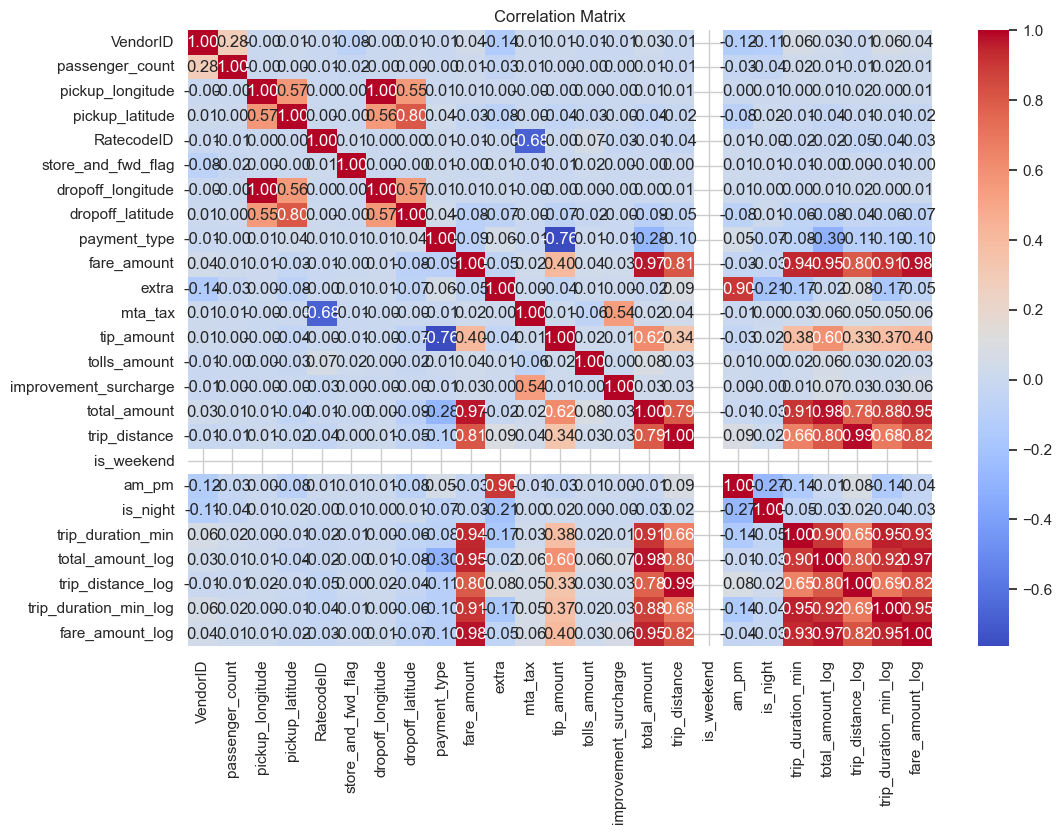

In [30]:
#Correlation Analysis (Numerical Variables)  step 6
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns
num_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
corr_matrix = num_df.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()


In [31]:
# Chi-Square Test (Categorical Features)

from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select categorical columns (already encoded)
cat_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'am_pm', 'is_night', 'is_weekend']

# Create a binned version of total_amount
df['fare_bin'] = pd.qcut(df['total_amount'], q=4, labels=['low','medium','high','very_high'])

# Scale categorical data for chi2
scaler = MinMaxScaler()
X_cat = scaler.fit_transform(df[cat_cols])
y_cat = df['fare_bin']

chi_scores = chi2(X_cat, y_cat.factorize()[0])

chi2_results = pd.DataFrame({'Feature': cat_cols, 'Chi2': chi_scores[0], 'p-value': chi_scores[1]})
chi2_results.sort_values('Chi2', ascending=False)






,Feature,Chi2,p-value
3,payment_type,3278.708897,0.000000e+00
5,is_night,54.010384,1.116353e-11
0,VendorID,53.469161,1.456186e-11
4,am_pm,18.740612,3.093229e-04
1,RatecodeID,4.477931,2.142672e-01
2,store_and_fwd_flag,1.225498,7.468955e-01
6,is_weekend,NaN,NaN


In [32]:
# Drop datetime columns before model training
datetime_cols = df.select_dtypes(include=['datetime64']).columns
X = df.drop(columns=['total_amount', 'fare_bin'] + list(datetime_cols))
y = df['total_amount']

# Confirm only numeric types remain
print(X.dtypes)


VendorID                                      int64
passenger_count                               int64
pickup_longitude                            float64
pickup_latitude                             float64
RatecodeID                                    int64
store_and_fwd_flag                            int64
dropoff_longitude                           float64
dropoff_latitude                            float64
payment_type                                  int64
fare_amount                                 float64
extra                                       float64
mta_tax                                     float64
tip_amount                                  float64
tolls_amount                                float64
improvement_surcharge                       float64
trip_distance                               float64
pickup_datetime_edt      datetime64[ns, US/Eastern]
pickup_hour                                   int32
pickup_month                                  int32
pickup_date 

In [33]:
# Drop datetime columns safely before model training
datetime_cols = df.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns
print("Datetime columns found:", list(datetime_cols))

# Define target
y = df['total_amount']

# Drop target + datetime columns from features
X = df.drop(columns=['total_amount'] + list(datetime_cols), errors='ignore')

# Optional: also drop any non-numeric columns (in case any remain)
X = X.select_dtypes(include=['int64', 'float64'])

print("Final columns used for model:\n", X.columns)


Datetime columns found: ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
Final columns used for model:
 Index(['VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'trip_distance',
       'is_weekend', 'am_pm', 'is_night', 'trip_duration_min',
       'total_amount_log', 'trip_distance_log', 'trip_duration_min_log',
       'fare_amount_log'],
      dtype='object')


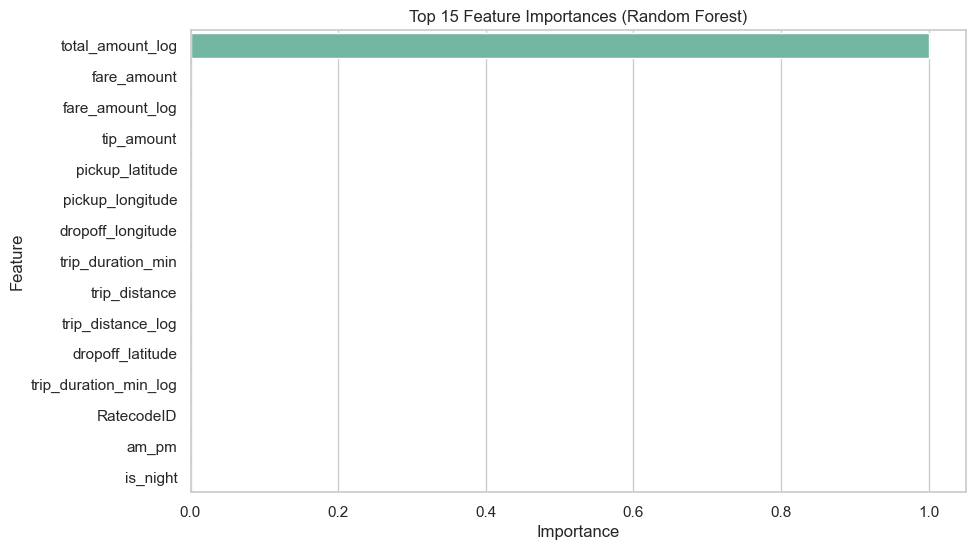

,Feature,Importance
20,total_amount_log,9.998773e-01
9,fare_amount,6.232840e-05
23,fare_amount_log,5.677473e-05
12,tip_amount,2.490805e-06
3,pickup_latitude,1.584061e-07
2,pickup_longitude,1.469771e-07
6,dropoff_longitude,1.320876e-07
19,trip_duration_min,1.170425e-07
15,trip_distance,1.071057e-07
21,trip_distance_log,8.564840e-08


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

importances.head(15)


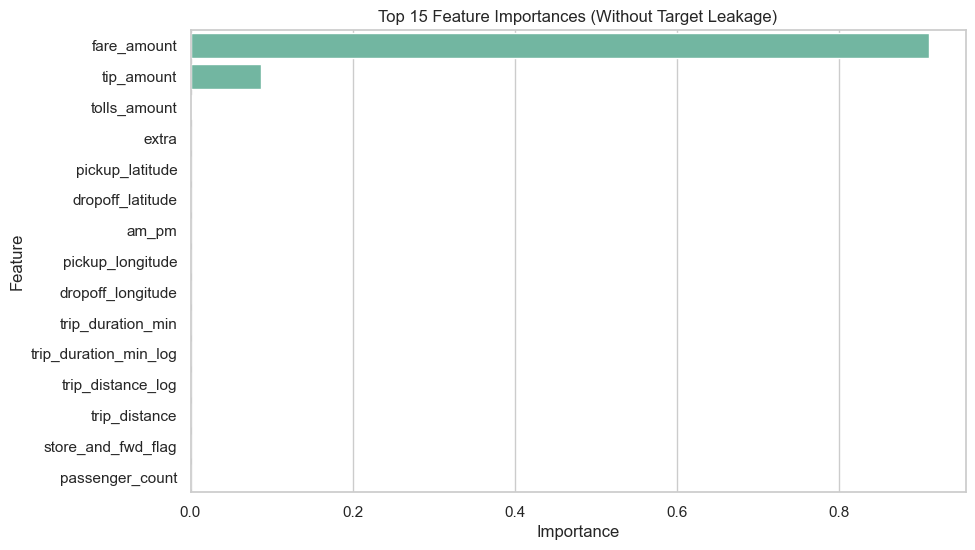

,Feature,Importance
9,fare_amount,0.910564
12,tip_amount,0.086623
13,tolls_amount,0.001863
10,extra,0.000855
3,pickup_latitude,0.000020
7,dropoff_latitude,0.000014
17,am_pm,0.000013
2,pickup_longitude,0.000010
6,dropoff_longitude,0.000010
19,trip_duration_min,0.000009


In [36]:
# Drop total_amount_log and any derived columns of total_amount before modeling
cols_to_drop = ['total_amount_log', 'fare_amount_log']  # add any similar ones
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns], errors='ignore')

# Re-train Random Forest for feature importance again
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train[X.columns.intersection(X_train.columns)], y_train)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Feature Importances (Without Target Leakage)')
plt.show()

importances.head(10)


In [43]:
# Identify any datetime or object columns accidentally left
print("🕓 Non-numeric columns in X:")
print(X.select_dtypes(exclude=['int64', 'float64']).dtypes)

# Drop any datetime or object-type columns if they exist
X = X.select_dtypes(include=['int64', 'float64'])

print("\n✅ Columns kept for modeling:")
print(X.columns.tolist())
print("Shape:", X.shape)


🕓 Non-numeric columns in X:
tpep_pickup_datetime                 datetime64[ns]
tpep_dropoff_datetime                datetime64[ns]
pickup_datetime_edt      datetime64[ns, US/Eastern]
pickup_hour                                   int32
pickup_month                                  int32
pickup_date                                  object
pickup_weekday                                int32
pickup_day_Thursday                            bool
pickup_day_Tuesday                             bool
pickup_day                                   object
pickup_weekday_num                            int32
fare_bin                                   category
dtype: object

✅ Columns kept for modeling:
['VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'trip_distance', 'is_weekend', 'am_pm', 'is_night'

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Split data again (safe)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'R² Score': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })

results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print("\n✅ Model Performance Comparison:")
print(results_df)



✅ Model Performance Comparison:
               Model  R² Score           MSE      RMSE       MAE
0  Linear Regression  1.000000  4.789324e-07  0.000692  0.000384
1   Ridge Regression  1.000000  4.538362e-06  0.002130  0.000804
3      Random Forest  0.999999  2.023110e-05  0.004498  0.000120
4  Gradient Boosting  0.999987  2.350218e-04  0.015330  0.006615
2   Lasso Regression  0.999431  9.955299e-03  0.099776  0.039546


In [ ]:
# The top-performing models are Linear Regression and Random Forest, for deployment, we’ll choose Random Forest — it’s more stable and handles nonlinear relationships better.

In [48]:
import joblib

# Save model and feature order together
model_info = {
    "model": models['Random Forest'],   # or your chosen best model
    "features": X.columns.tolist()
}

joblib.dump(model_info, "best_random_forest_model.pkl")
print("✅ Model and feature order saved!")


✅ Model and feature order saved!


In [45]:
import joblib

# Choose the best model
best_model = models['Random Forest']

# Save model
joblib.dump(best_model, 'best_random_forest_model.pkl')

print("✅ Best model saved successfully as 'best_random_forest_model.pkl'")


✅ Best model saved successfully as 'best_random_forest_model.pkl'


In [49]:
# extras 

import joblib
obj = joblib.load("best_random_forest_model.pkl")
type(obj), (list(obj.keys()) if isinstance(obj, dict) else "estimator direct")


(dict, ['model', 'features'])

In [50]:
joblib.dump(best_model, "best_random_forest_model.pkl")


['best_random_forest_model.pkl']

In [51]:
joblib.dump({"model": best_model, "features": X.columns.tolist()}, "best_random_forest_model.pkl")


['best_random_forest_model.pkl']